In [1]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization, Conv1D, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from src.helper_functions import plot_reconstruction
import seaborn as sns


In [2]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=128000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128),
    threshold_level=0.5
)


Found 125440 files for Training set
Found 2560 files for Test set


In [3]:
img_width = 128
img_height = 128
kernel_size = 5
strides = 2

In [4]:
class Time_Freq_Autoencoder_Builder:
    
    def build(width, height, depth, filters=(32,64,128,256), latent_dim=256, kernel_size=5):
        
        strides = 2
        
        input_shape = (height, width, depth)
        inputs = Input(shape = input_shape)
        
        chan_dim = -1
        
        x_time = Reshape(target_shape=(height,width))(inputs)
        x_freq = Reshape(target_shape=(height,width))(tf.transpose(inputs, perm=[0,2,1,3]))
        
        for f in filters:
            
            x_time = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_time)
            x_time = BatchNormalization(axis=chan_dim)(x_time)
            
        x_time = Flatten()(x_time)
        latent_time = Dense(latent_dim//2)(x_time)
        
        for f in filters:
            
            x_freq = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_freq)
            x_freq = BatchNormalization(axis=chan_dim)(x_freq)
            
        x_freq = Flatten()(x_freq)
        latent_freq = Dense(latent_dim//2)(x_freq)
        
        
        latent_concat = tf.keras.layers.Concatenate(axis=1)([latent_time, latent_freq])
        
        encoder = Model(inputs, latent_concat, name='encoder')
        
        latent_inputs = Input(shape=((latent_dim//2)*2))
        
        x = Dense(16384, activation='relu')(latent_inputs)
        x = Reshape(target_shape=(8,8,256))(x)
        
        for f in filters[::-1]:
            
            x = Conv2DTranspose(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
            x = BatchNormalization(axis=chan_dim)(x)
            
        x = Conv2DTranspose(depth, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
        
        outputs = x
        
        decoder = Model(latent_inputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        return (encoder, decoder, autoencoder)
    

class Time_Freq_Autoencoder(tf.keras.Model):
    
    def __init__(self, image_width, image_height, image_depth=1, latent_dim=256, kernel_size=5):
        super().__init__()
        
        self.encoder, self.decoder, self.autoencoder = Time_Freq_Autoencoder_Builder.build(width=image_width, height=image_height, depth=image_depth, latent_dim=256, kernel_size=kernel_size)
        
    def call(self, x):
        autoencoded = self.autoencoder(x)
        return autoencoded
    
autoencoder = Time_Freq_Autoencoder(image_width=img_width, image_height=img_height, latent_dim=256, kernel_size=5)

In [5]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [6]:
autoencoder.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 128, 128, 1)  0          ['input_1[0][0]']                
 mbda)                                                                                            
                                                                                                  
 reshape (Reshape)              (None, 128, 128)     0           ['input_1[0][0]']                
                                                                                            

In [7]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=25,
                       validation_data=data_gen.test)

Epoch 1/25


2022-08-19 21:18:18.812724: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3920/3920 [==============================] - 2369s 604ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 2/25
3920/3920 [==============================] - 2371s 605ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 3/25
3920/3920 [==============================] - 2369s 604ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 4/25
3920/3920 [==============================] - 2371s 605ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/25
3920/3920 [==============================] - 2372s 605ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/25
3920/3920 [==============================] - 2373s 605ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/25
3920/3920 [==============================] - 2366s 603ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/25
3920/3920 [==============================] - 2366s 603ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/25
3920/3920 [==============================] - 2367s 604ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/25
3920/3920 [=========================

In [ ]:
autoencoder_path = 'data/autoencoder_256dim_time_freq_128k_simplified_25e'

autoencoder.save(autoencoder_path)

In [7]:
autoencoder = tf.keras.models.load_model(autoencoder_path)

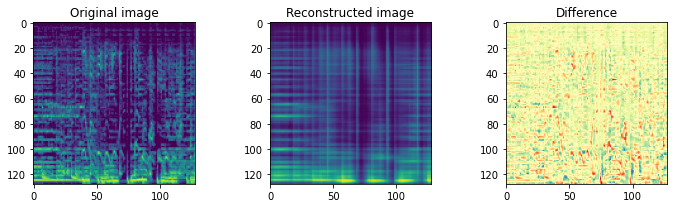

In [11]:
test_img = data_gen.take(6)[0]
prediction = autoencoder(test_img)

plot_reconstruction(test_img, prediction, 1)

In [12]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=256, output_size=(128, 128),
                        threshold_level=0.5
                        )

Found 278581 files for Generator set


In [13]:
latent_space.build()
latent_space.save(autoencoder_path)

Getting predictions from autoencoder...
[============================================================>] 8705 / 8705

82.48 minutes elapsed
Building tracks dataframe...
size of results 1114240
Track dataframe built. 79.45 minutes elapsed
Building artist distributions...
Artist distributions built. 0.01 minutes elapsed
Building genre distributions...
Genre distributions built. 3.98 minutes elapsed
Latent Space Built.


In [ ]:
latent_space.tracks

In [76]:
latent_space.tracks[latent_space.tracks.artist_name.str.contains('Vangelis')][['track_id','track_name','artist_name']]

,track_id,track_name,artist_name
27088,0l6TWDKQVA0MIGo15LpzMD,Chronos - Ambrosia Soundtrack Version,Nikos Vangelis
76059,27iy87clL6mJQh9ybqLNK8,Fields of Coral,Vangelis
84170,2LxEIWrZkzfc55c3rk05DH,Tears in Rain,Vangelis
100414,2oDR7QWoLBk9VYMwsFbRGq,Love Theme,Vangelis
130345,3e4VawNTLG2hot2Gvkug8m,Horns,Dimitri Vangelis & Wyman
161892,4Wiub4bQiJTlS224CC19f8,Phantom,Dimitri Vangelis & Wyman
182792,575blCgesVtCu0HEYaIcas,Blade Runner Blues,Vangelis
187450,5FQEeo3o0tPNxrsQPcmwlX,Changes,Dimitri Vangelis & Wyman
199924,5avVpUakfMHD6qGpaH26CF,Conquest of Paradise,Vangelis
217643,65JKNFrK9D0NYjK0I1fiHK,Silence - Interlude,Nikos Vangelis


/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_5617/2091795571.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.imshow([latent_space.results[latent_space.results.id == '6bA4RtHm4n249OETFGpudi'].std()], aspect=80)


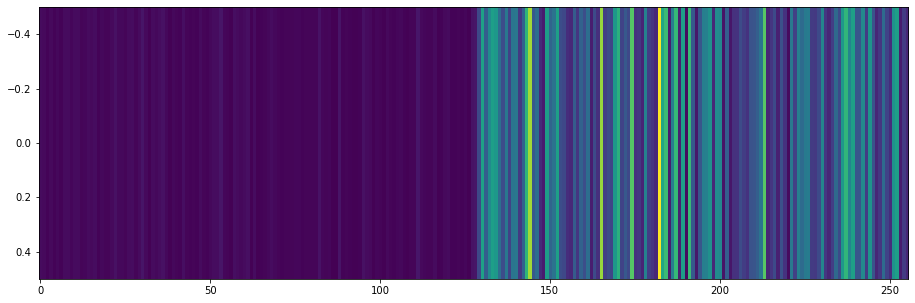

In [56]:
plt.figure(figsize=(20,5))
plt.imshow([latent_space.results[latent_space.results.id == '6bA4RtHm4n249OETFGpudi'].std()], aspect=80)

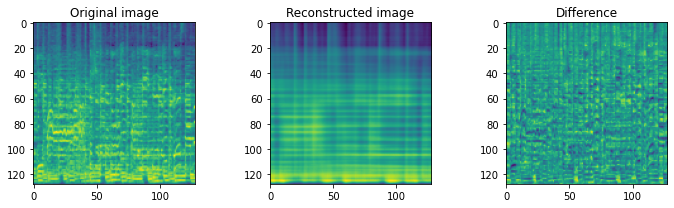

,index,track_name,artist_name,track_uri,similarity
0,236054,Main Titles,Vangelis,spotify:track:6baN5nSUIVTsUyugSuAj7U,1.000000
1,57400,O Silly Me,Boy Azooga,spotify:track:1beZ2cDsMh2CCk7JAl3BvI,0.557025
2,265418,Revenge,Justin Faust,spotify:track:7dsg1bIt0TUl1t0OCNusKm,0.548893
3,213804,Koul Non,King Posse,spotify:track:5ygnRX6cC2SswrGC70lId4,0.541350
4,58862,The Future,Tube & Berger,spotify:track:1e806Bcl0zWAr4Q3YhaMJD,0.531433
5,228612,"Nothing I've Ever Known (From ""Spirit: Stallio...",Boris Björn Bagger,spotify:track:6OR6gGuLMdEwP5iHSHZEAW,0.527560
6,243813,Väiksed paadid (taani) [feat. Heiti Kender],Tõnu Raadik,spotify:track:6oubR8vvi4gGhqFwiaqNVI,0.527452
7,59767,I Believe (When I Fall In Love It Will Be Fore...,Art Garfunkel,spotify:track:1fdQg2yrTYCMOviVCw1Xdh,0.525224
8,52653,Atlas - Tuff City Kids Remix,Tuff City Kids,spotify:track:1TPjBCmPBFZHW2rjx5EPxz,0.521038
9,146175,Floating,DJ Style,spotify:track:45kl5ivm7tiSXJl1onk707,0.520630


,artist_name,similarity
0,Kreutzfeldt,0.545201
1,Ivory (IT),0.516684
2,Romulus,0.483274
3,Masaladosa,0.461649
4,Cv313,0.461442
5,Funk D'void,0.458560
6,Seckin,0.453387
7,Digitzz,0.447434
8,Jneiro Jarel,0.445087
9,Skin On Skin,0.444935


,genre,similarity
0,scottish techno,0.402062
1,israeli techno,0.396539
2,beach house,0.388178
3,birmingham grime,0.377768
4,new jack swing,0.375853
5,trival,0.375675
6,uk bass,0.374420
7,r&b,0.371908
8,german house,0.369632
9,vogue,0.364135


In [77]:
seed = 236054
latent_space.plot_reconstruction(seed)
display(latent_space.get_similar_tracks_by_index(seed))
display(latent_space.get_similar_artists_by_index(seed))
display(latent_space.get_similar_genres_by_index(seed))

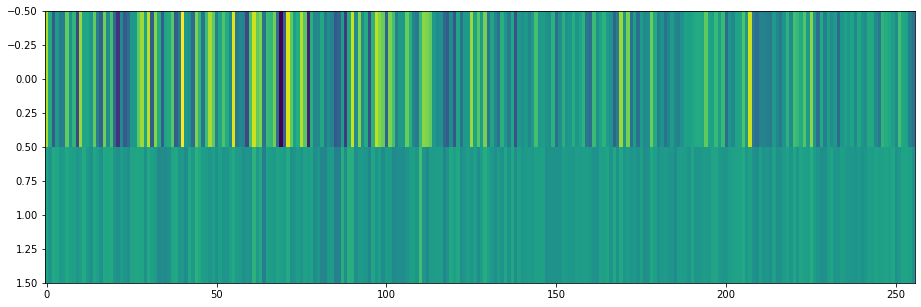

In [73]:
import pandas as pd
plt.figure(figsize=(20,5))

compare = pd.concat([latent_space.tracks[latent_space.tracks.id == '6bA4RtHm4n249OETFGpudi'][latent_space.latent_cols], latent_space.genres[latent_space.genres.index == 'italian disco'][latent_space.latent_cols]])

plt.imshow(compare, aspect=40)
